# Live Auction

Recently the human bidders on the site are becoming increasingly frustrated with their inability to win auctions vs. robots. In order to rebuild customer happiness, the company is seeking to eliminate robot bidders from the site.

The goal of this project is to provide Live Auction with a model that will identify and flag bidders if they are a robot and prevent unfair bidding activity.

### Profile of a Robot

My hypothesis is that a robot bidder will have these characteristics:
1. They do lots of bids
2. Wait until the end of the auction
3. Bid in defined increments all the time for a given auction
4. Bid quickly
5. Execute multiple simultaneous bids.

In [3]:
############### Imports ################

# Basic Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Infrastructure
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.utils import resample
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

import boto3
import io

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble



In [4]:
############### Bring in Data ############
start_time = time.time()
s3 = boto3.client('s3')

#Bring in Training Data
obj = s3.get_object(Bucket='data-science-project-data', Key='Human_or_Robot/train.csv')
train = pd.read_csv(io.BytesIO(obj['Body'].read()))
train.set_index('bidder_id', inplace=True)

# Bring in Test Data
obj = s3.get_object(Bucket='data-science-project-data', Key='Human_or_Robot/test.csv')
test = pd.read_csv(io.BytesIO(obj['Body'].read()))
test.set_index('bidder_id', inplace=True)


# Bring in bids data
obj = s3.get_object(Bucket='data-science-project-data', Key='Human_or_Robot/bids.csv')
bids = pd.read_csv(io.BytesIO(obj['Body'].read()))

print("-- Execution time: %s seconds ---" % (time.time() - start_time))


-- Execution time: 27.77508044242859 seconds ---


## Exploratory Data Analysis

### Train Data

In [39]:
train.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 4 columns):
bidder_id          2013 non-null object
payment_account    2013 non-null object
address            2013 non-null object
outcome            2013 non-null float64
dtypes: float64(1), object(3)
memory usage: 63.0+ KB


In [47]:
#Serious class imbalance. Will need to deal with this when join the tables from the bids data onto this to create a final feature dataset
train['outcome'].value_counts()

0.0    1910
1.0     103
Name: outcome, dtype: int64

### Bids Data

In [41]:
bids.head(10)

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3
5,5,e8291466de91b0eb4e1515143c7f74dexy2yr,3vi4t,mobile,phone7,9759243157894736,ru,91.107.221.27,vasstdc27m7nks3
6,6,eef4c687daf977f64fc1d08675c44444raj3s,kjlzx,mobile,phone2,9759243210526315,th,152.235.155.159,j9nl1xmo6fqhcc6
7,7,ab056855c9ca9d36390feae1fa485883issyg,f5f6k,home goods,phone8,9759243210526315,id,3.210.112.183,hnt6hu93a3z1cpc
8,8,d600dc03b11e7d782e1e4dae091b084a1h5ch,h7jjx,home goods,phone9,9759243210526315,th,103.64.157.225,vasstdc27m7nks3
9,9,a58ace8b671a7531c88814bc86b2a34cf0crb,3zpkj,sporting goods,phone4,9759243210526315,za,123.28.123.226,vasstdc27m7nks3


In [9]:
bids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7656334 entries, 0 to 7656333
Data columns (total 9 columns):
bid_id         int64
bidder_id      object
auction        object
merchandise    object
device         object
time           int64
country        object
ip             object
url            object
dtypes: int64(2), object(7)
memory usage: 525.7+ MB


-- Execution time: 28.38271474838257 seconds ---


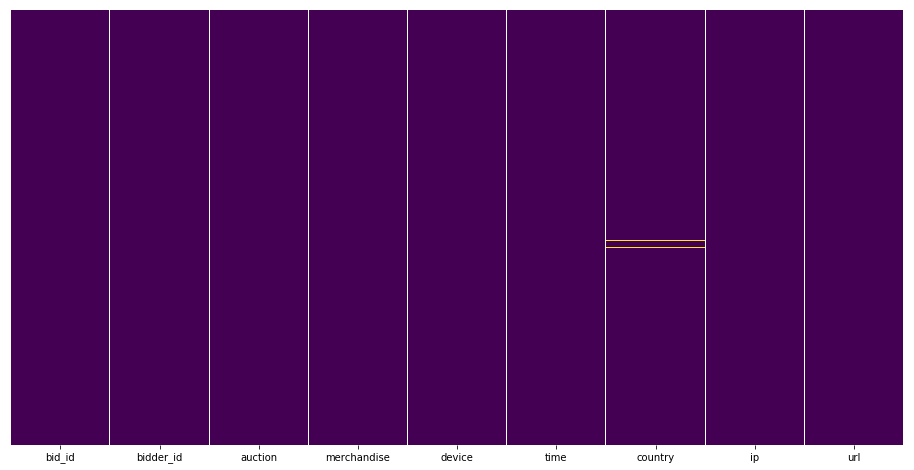

In [13]:
# Is there any missing data?
plt.figure(figsize=(16,8))
start_time = time.time()
sns.heatmap(bids.isnull(), yticklabels=False, cbar=False, cmap='viridis')
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

Country is only missing a little. The rest is filled in.

### Time Feature Engineering

In [7]:
#Find Earlierest Time stamp
sorted_bids = bids.sort_values(by=['time'], ascending=True)
sorted_bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
2351187,2351187,76218e14c379c12d599dae9e1c00b61a3i5b2,6hpvy,sporting goods,phone1161,9631916842105263,cz,121.169.96.51,f33fl83l4vrg6is
2351202,2351202,29c103503e1d6ace5626fb07a5ab0dafrtjvs,wpee4,jewelry,phone412,9631916842105263,ru,63.82.37.102,via8q041tf3xrke
2351201,2351201,0ea62aaa9c3ffcc6db584cb69c1f6c4bcripp,b6zck,mobile,phone99,9631916842105263,lt,181.144.42.116,vasstdc27m7nks3
2351200,2351200,6e178db6d17d21aa88aaca5bf15c2761lc500,jqx39,jewelry,phone99,9631916842105263,sa,174.12.78.255,omwhmwzvrn6ycq6
2351199,2351199,b7c4f67613c2af7e544f01359d4fccc7l5f7y,du967,office equipment,phone348,9631916842105263,tr,21.10.208.37,vasstdc27m7nks3


In [8]:
#Find Time Difference, the smallest unit
sorted_bids['Time Shift'] = sorted_bids['time'].diff()
time_diff = sorted_bids['Time Shift'].value_counts().to_frame().reset_index()

In [9]:
#This is to be able to fully see the value instead of the exponent version
time_diff['converted'] = time_diff['index'].apply(lambda x: '%.3f' % x)
time_diff

,index,Time Shift,converted
0,0.000000e+00,6879805,0.000
1,5.263158e+07,734681,52631579.000
2,5.263158e+07,40817,52631578.000
3,1.052632e+08,904,105263158.000
4,1.052632e+08,105,105263157.000
5,1.578947e+08,10,157894737.000
6,1.578947e+08,3,157894736.000
7,5.002111e+13,2,50021105263158.000
8,5.263158e+08,1,526315790.000
9,4.210526e+08,1,421052632.000


In [5]:
#Create function to time into a real time stamp. Assuming min_time_diff is a second.
def convert_time(time):
    min_time_diff = 52631579
    #Time in seconds of 1/1/2010 12:00AM since 1970
    init_seconds = 1262347200
    #Minimum value from dataset
    min_time = 9631916842105263

    b = init_seconds - (1/min_time_diff)*min_time
    timestamp = (1/min_time_diff)*time + b
    return datetime.datetime.fromtimestamp(timestamp)
    

In [5]:
#Test
convert_time(9759243157894736)

datetime.datetime(2010, 1, 29, 11, 59, 59, 997581)

In [28]:
#Create Subset to test quickly
bid_subset = bids.head()

In [29]:
#Lets build a new column and see if accurate
bid_subset['Converted Time'] = bid_subset['time'].apply(lambda x: convert_time(x))

In [31]:
bid_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
bid_id            5 non-null int64
bidder_id         5 non-null object
auction           5 non-null object
merchandise       5 non-null object
device            5 non-null object
time              5 non-null int64
country           5 non-null object
ip                5 non-null object
url               5 non-null object
Converted Time    5 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 480.0+ bytes


In [6]:
#Apply to entire dataset
bids['Converted Time'] = bids['time'].apply(lambda x: convert_time(x))

### Bids Features Engineering

In [7]:
#### Create aggregate dataframe ########

start_time = time.time()
# Create bidder aggregation
bidder_aggregate = bids.groupby(['bidder_id'])['bid_id'].count().to_frame()
bidder_aggregate.columns = ['Total Bids']

# Add other columns
bidder_aggregate['Total Auctions'] = bids.groupby(['bidder_id'])['auction'].nunique()
bidder_aggregate['Number of Merchandise'] = bids.groupby(['bidder_id'])['merchandise'].nunique()
bidder_aggregate['Number of Device'] = bids.groupby(['bidder_id'])['device'].nunique()
bidder_aggregate['Number of IPs'] = bids.groupby(['bidder_id'])['ip'].nunique()
bidder_aggregate['Number of URLs'] = bids.groupby(['bidder_id'])['url'].nunique()

print("-- Execution time: %s seconds ---" % (time.time() - start_time))

-- Execution time: 64.24801540374756 seconds ---


In [8]:
bidder_aggregate.head()

,Total Bids,Total Auctions,Number of Merchandise,Number of Device,Number of IPs,Number of URLs
bidder_id,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1
002d229ffb247009810828f648afc2ef593rb,2,1,1,2,1,1
0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,3,1,3,3,2
00486a11dff552c4bd7696265724ff81yeo9v,20,13,1,8,10,7


#### Bidder- Auction

Goal: What I want to pull out of this section (By bidder)
1. Min Mean Time per bid
2. Max Mean time per bid
3. Mean mean time per bid
4. Mean number of bids per auction
5. Count Auction Wins (Last bid equal Auction last bid)
6. Mean Time Particpation
7. Median Time particpation
8. Max Time particpation
9. Min Time particpation
10. Mean started ratio
11. Median started ratio
12. Max Started ratio
13. Min Started ratio



In [8]:
#Create this dataframe
bidder_auction = bids.groupby(['bidder_id','auction'])['Converted Time'].min().to_frame()
bidder_auction.columns = ['First Bid Time']
bidder_auction['Last Bid Time'] = bids.groupby(['bidder_id','auction'])['Converted Time'].max().to_frame()
bidder_auction['Bid Time Difference'] = bidder_auction['Last Bid Time'] - bidder_auction['First Bid Time']
bidder_auction['Number of Bids'] = bids.groupby(['bidder_id','auction'])['time'].count().to_frame()
bidder_auction['Mean Time per Bid'] = bidder_auction['Bid Time Difference']/bidder_auction['Number of Bids']


In [10]:
bidder_auction.head(20)

First Bid Time  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-17 20:48:55.998586   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 03:35:17.997438   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-17 11:21:44.998620   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-16 14:31:15.998695   
                                      efh5o   2010-01-17 18:51:31.998593   
                                      obbny   2010-01-03 06:45:33.999846   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   2010-01-01 15:49:21.999986   
                                      9ul86   2010-01-02 06:35:38.999933   
                                      cci6c   2010-01-03 00:56:10.999867   
                                      drdr4   2010-01-15 13:02:53.998786   
                                      eaz7i   2010-01-03 22:59:44.999788   
                                      gst86   2010-01-01 19:30:33.999973   
                                      lx0hm   2010-01-02 20:04:19.999884   
                                      lz5gg   2010-01-03 23:01:57.999787   
                                      nf1v1   2010-01-15 13:15:41.998786   
                                      no958   2010-01-01 15:47:53.999986   
                                      opnq4   2010-01-04 00:02:18.999784   
                                      qvhei   2010-01-17 08:35:51.998630   
                                      ss2rr   2010-01-18 10:45:20.998536   
0051aef3fdeacdadba664b9b3b07e04e4coc6 d2q2z   2010-01-29 12:08:55.997580   

                                                           Last Bid Time  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-17 20:48:55.998586   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 03:35:19.997438   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-17 11:21:44.998620   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-16 14:31:15.998695   
                                      efh5o   2010-01-17 18:51:31.998593   
                                      obbny   2010-01-03 06:45:33.999846   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   2010-01-02 12:11:55.999913   
                                      9ul86   2010-01-02 06:35:38.999933   
                                      cci6c   2010-01-03 00:56:10.999867   
                                      drdr4   2010-01-15 14:49:42.998780   
                                      eaz7i   2010-01-03 22:59:44.999788   
                                      gst86   2010-01-03 08:55:27.999838   
                                      lx0hm   2010-01-02 20:04:19.999884   
                                      lz5gg   2010-01-04 08:11:20.999754   
                                      nf1v1   2010-01-15 13:15:41.998786   
                                      no958   2010-01-02 20:04:12.999884   
                                      opnq4   2010-01-04 07:14:23.999758   
                                      qvhei   2010-01-17 08:35:51.998630   
                                      ss2rr   2010-01-18 10:45:20.998536   
0051aef3fdeacdadba664b9b3b07e04e4coc6 d2q2z   2010-01-30 05:45:25.997517   

                                                 Bid Time Difference  \
bidder_id                             auction                          
001068c415025a009fee375a12cff4fcnht8y 4ifac          0 days 00:00:00   
002d229ffb247009810828f648afc2ef593rb 2tdw2          0 days 00:00:02   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny          0 days 00:00:00   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6          0 days 00:00:00   
                                      efh5o          0 days 00:00:00   
                                      obbny          0 days 00:00:00   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   0 days 20:22:33.999927   
                                      9ul86          0 days 00:0

#### Auction

Want to join this datafram to the bidd_acution dataframe

In [9]:
# Create Auction Dataframe
auction = bids.groupby(['auction'])['Converted Time'].min().to_frame()
auction.columns = ['Auction Started']

#Create other columns
auction['Auction Ended'] = bids.groupby(['auction'])['Converted Time'].max().to_frame()
auction['Auction Time Difference'] = auction['Auction Ended'] - auction['Auction Started']
auction['Number of Bidders'] = bids.groupby(['auction'])['bidder_id'].nunique().to_frame()
#auction['Number of Bids'] = bids.groupby(['auction'])['bidder_id'].count().to_frame()

In [28]:
auction.head(5)

,Auction Started,Auction Ended,Auction Time Difference,Number of Bidders
auction,,,,
00270,2010-01-16 06:18:47.998724,2010-01-18 11:57:04.998531,2 days 05:38:16.999807,26
008vv,2010-01-29 12:39:58.997578,2010-01-29 18:05:25.997559,0 days 05:25:26.999981,2
00cwr,2010-01-15 12:19:30.998789,2010-01-16 04:07:54.998732,0 days 15:48:23.999943,11
00do0,2010-01-29 12:25:32.997579,2010-01-29 15:16:58.997569,0 days 02:51:25.999990,2
00hjy,2010-01-29 12:52:56.997577,2010-02-01 11:08:52.997324,2 days 22:15:55.999747,20


In [13]:
#The mean auction lasts 5 days This seems plausible with reverse engineering the time.
auction['Auction Time Difference'].mean()

Timedelta('5 days 10:48:09.695629')

In [10]:
#Join Auction with Bidder_auction
bidder_auction_full = bidder_auction.join(auction, how='inner')
bidder_auction_full.head(5)

First Bid Time  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-17 20:48:55.998586   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 03:35:17.997438   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-17 11:21:44.998620   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-16 14:31:15.998695   
                                      efh5o   2010-01-17 18:51:31.998593   

                                                           Last Bid Time  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-17 20:48:55.998586   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 03:35:19.997438   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-17 11:21:44.998620   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-16 14:31:15.998695   
                                      efh5o   2010-01-17 18:51:31.998593   

                                              Bid Time Difference  \
bidder_id                             auction                       
001068c415025a009fee375a12cff4fcnht8y 4ifac              00:00:00   
002d229ffb247009810828f648afc2ef593rb 2tdw2              00:00:02   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny              00:00:00   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6              00:00:00   
                                      efh5o              00:00:00   

                                               Number of Bids  \
bidder_id                             auction                   
001068c415025a009fee375a12cff4fcnht8y 4ifac                 1   
002d229ffb247009810828f648afc2ef593rb 2tdw2                 2   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny                 1   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6                 1   
                                      efh5o                 1   

                                              Mean Time per Bid  \
bidder_id                             auction                     
001068c415025a009fee375a12cff4fcnht8y 4ifac            00:00:00   
002d229ffb247009810828f648afc2ef593rb 2tdw2            00:00:01   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny            00:00:00   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6            00:00:00   
                                      efh5o            00:00:00   

                                                         Auction Started  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-01 12:11:54.999999   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 02:49:13.997441   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-01 12:00:04.000000   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-15 12:09:25.998790   
                                      efh5o   2010-01-16 03:27:02.998735   

                                                           Auction Ended  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-18 00:06:48.998574   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 13:05:02.997404   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-18 11:59:43.998531   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-18 10:15:33.998537   
                                      efh5o   2010-01-18 11:58:44.998531   

                                              Auction Time Difference  \
bidder_id                             auction                           
001068c415025a009fee375a12cff4fcnht8y 4ifac   16 days 11:54:53.998575   
002d229ffb247009810828f648afc2ef593rb 2tdw2    0 days 10:15:48.999963   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   16 days 23:59:39.998531   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6    2 days 22:06:07.999747   
                                      efh5o    2 days 08:31:41.999796   

    

In [11]:
#Add More Features

#Particpation measure. How much of the auction particpated in (time)
bidder_auction_full['Time Particpation'] = (((bidder_auction_full['Auction Ended'] 
                                                 - bidder_auction_full['First Bid Time'])/bidder_auction_full['Auction Time Difference']))*100

#Started ratio (When got in the higher the number the later)
bidder_auction_full['Started Ratio'] = (((bidder_auction_full['First Bid Time'] 
                                                 - bidder_auction_full['Auction Started'])/bidder_auction_full['Auction Time Difference']))*100

#Won Auction
bidder_auction_full['Won Auction'] = bidder_auction_full['Last Bid Time']==bidder_auction_full['Auction Ended']
bidder_auction_full.head(10)


First Bid Time  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-17 20:48:55.998586   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 03:35:17.997438   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-17 11:21:44.998620   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-16 14:31:15.998695   
                                      efh5o   2010-01-17 18:51:31.998593   
                                      obbny   2010-01-03 06:45:33.999846   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   2010-01-01 15:49:21.999986   
                                      9ul86   2010-01-02 06:35:38.999933   
                                      cci6c   2010-01-03 00:56:10.999867   
                                      drdr4   2010-01-15 13:02:53.998786   

                                                           Last Bid Time  \
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac   2010-01-17 20:48:55.998586   
002d229ffb247009810828f648afc2ef593rb 2tdw2   2010-01-31 03:35:19.997438   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny   2010-01-17 11:21:44.998620   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6   2010-01-16 14:31:15.998695   
                                      efh5o   2010-01-17 18:51:31.998593   
                                      obbny   2010-01-03 06:45:33.999846   
00486a11dff552c4bd7696265724ff81yeo9v 6plix   2010-01-02 12:11:55.999913   
                                      9ul86   2010-01-02 06:35:38.999933   
                                      cci6c   2010-01-03 00:56:10.999867   
                                      drdr4   2010-01-15 14:49:42.998780   

                                              Bid Time Difference  \
bidder_id                             auction                       
001068c415025a009fee375a12cff4fcnht8y 4ifac              00:00:00   
002d229ffb247009810828f648afc2ef593rb 2tdw2              00:00:02   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny              00:00:00   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6              00:00:00   
                                      efh5o              00:00:00   
                                      obbny              00:00:00   
00486a11dff552c4bd7696265724ff81yeo9v 6plix       20:22:33.999927   
                                      9ul86              00:00:00   
                                      cci6c              00:00:00   
                                      drdr4       01:46:48.999994   

                                               Number of Bids  \
bidder_id                             auction                   
001068c415025a009fee375a12cff4fcnht8y 4ifac                 1   
002d229ffb247009810828f648afc2ef593rb 2tdw2                 2   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny                 1   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6                 1   
                                      efh5o                 1   
                                      obbny                 1   
00486a11dff552c4bd7696265724ff81yeo9v 6plix                 2   
                                      9ul86                 1   
                                      cci6c                 1   
                                      drdr4                 2   

                                              Mean Time per Bid  \
bidder_id                             auction                     
001068c415025a009fee375a12cff4fcnht8y 4ifac            00:00:00   
002d229ffb247009810828f648afc2ef593rb 2tdw2            00:00:01   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny            00:00:00   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6            00:00:00   
                                      efh5o            00:00:00   
                                      obbny            00:00:00   
00486a11dff552c4bd7696265724ff81yeo9v 6plix     10:11:16.999963   
                   

In [12]:
#Want to be able to do grouping by some time period. To see how many auctions occured in that time span. Then could do group by bidder, time period,
# and then count how many auctions are going on. This will tell us how many simultaneous they are bidding on.

In [13]:
# Now time to aggregate

bidder_auction_full_aggregate = bidder_auction_full.groupby(['bidder_id'])['Mean Time per Bid'].min().to_frame()
bidder_auction_full_aggregate.columns = ['Min Mean Time per Bid']
bidder_auction_full_aggregate['Max Mean Time per Bid'] = bidder_auction_full.groupby(['bidder_id'])['Mean Time per Bid'].max().to_frame()
#bidder_auction_full_aggregate['Mean Mean Time per Bid'] = bidder_auction_full.groupby(['bidder_id'])['Mean Time per Bid'].mean().to_frame()
bidder_auction_full_aggregate['Min Time Particpation'] = bidder_auction_full.groupby(['bidder_id'])['Time Particpation'].min().to_frame()
bidder_auction_full_aggregate['Max Time Particpation'] = bidder_auction_full.groupby(['bidder_id'])['Time Particpation'].max().to_frame()
bidder_auction_full_aggregate['Mean Time Particpation'] = bidder_auction_full.groupby(['bidder_id'])['Time Particpation'].mean().to_frame()
bidder_auction_full_aggregate['Min Started Ratio'] = bidder_auction_full.groupby(['bidder_id'])['Started Ratio'].min().to_frame()
bidder_auction_full_aggregate['Max Started Ratio'] = bidder_auction_full.groupby(['bidder_id'])['Started Ratio'].max().to_frame()
bidder_auction_full_aggregate['Mean Started Ratio'] = bidder_auction_full.groupby(['bidder_id'])['Started Ratio'].mean().to_frame()
bidder_auction_full_aggregate['Auctions Won'] = bidder_auction_full[bidder_auction_full['Won Auction']==True].groupby(['bidder_id'])['Won Auction'].count().to_frame()

bidder_auction_full_aggregate.fillna(0, inplace=True)


bidder_auction_full_aggregate.head(5)

,Min Mean Time per Bid,Max Mean Time per Bid,Min Time Particpation,Max Time Particpation,Mean Time Particpation,Min Started Ratio,Max Started Ratio,Mean Started Ratio,Auctions Won
bidder_id,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,00:00:00,00:00:00,0.833021,0.833021,0.833021,99.166979,99.166979,99.166979,0.0
002d229ffb247009810828f648afc2ef593rb,00:00:01,00:00:01,92.519419,92.519419,92.519419,7.480581,7.480581,7.480581,0.0
0030a2dd87ad2733e0873062e4f83954mkj86,00:00:00,00:00:00,6.037596,6.037596,6.037596,93.962404,93.962404,93.962404,0.0
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,00:00:00,00:00:00,30.286189,89.519874,60.732761,10.480126,69.713811,39.267239,0.0
00486a11dff552c4bd7696265724ff81yeo9v,00:00:00,14:08:09.499949,1.860380,99.080406,65.955096,0.919594,98.139620,34.044904,0.0


### Final Bids Data Frame

In [14]:
# Combining To make finall bidder aggreate dataframe

bidder_features = bidder_aggregate.join(bidder_auction_full_aggregate, how='inner')
bidder_features.head()

,Total Bids,Total Auctions,Number of Merchandise,Number of Device,Number of IPs,Number of URLs,Min Mean Time per Bid,Max Mean Time per Bid,Min Time Particpation,Max Time Particpation,Mean Time Particpation,Min Started Ratio,Max Started Ratio,Mean Started Ratio,Auctions Won
bidder_id,,,,,,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,00:00:00,00:00:00,0.833021,0.833021,0.833021,99.166979,99.166979,99.166979,0.0
002d229ffb247009810828f648afc2ef593rb,2,1,1,2,1,1,00:00:01,00:00:01,92.519419,92.519419,92.519419,7.480581,7.480581,7.480581,0.0
0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,00:00:00,00:00:00,6.037596,6.037596,6.037596,93.962404,93.962404,93.962404,0.0
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,3,1,3,3,2,00:00:00,00:00:00,30.286189,89.519874,60.732761,10.480126,69.713811,39.267239,0.0
00486a11dff552c4bd7696265724ff81yeo9v,20,13,1,8,10,7,00:00:00,14:08:09.499949,1.860380,99.080406,65.955096,0.919594,98.139620,34.044904,0.0


In [15]:
#Convert Time Delta to seconds
bidder_features['Max Mean Time per Bid'] = bidder_features['Max Mean Time per Bid'].apply(lambda x: x.total_seconds())
bidder_features['Min Mean Time per Bid'] = bidder_features['Min Mean Time per Bid'].apply(lambda x: x.total_seconds())

### Build Training Data Set

In [16]:
# Combine the train with the features generated
training_set = train.join(bidder_features, how='inner')
training_set.head()

,payment_account,address,outcome,Total Bids,Total Auctions,Number of Merchandise,Number of Device,Number of IPs,Number of URLs,Min Mean Time per Bid,Max Mean Time per Bid,Min Time Particpation,Max Time Particpation,Mean Time Particpation,Min Started Ratio,Max Started Ratio,Mean Started Ratio,Auctions Won
bidder_id,,,,,,,,,,,,,,,,,,
91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,24,18,1,14,20,1,0.000000,24132.999976,2.763636,98.124047,52.532592,1.875953,97.236364,47.467408,0.0
624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,3,1,1,2,3,2,40958.666626,40958.666626,64.785744,64.785744,64.785744,35.214256,35.214256,35.214256,0.0
1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4,4,1,2,4,2,0.000000,0.000000,5.823871,46.591294,24.336129,53.408706,94.176129,75.663871,0.0
4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1,1,1,1,1,1,0.000000,0.000000,3.591540,3.591540,3.591540,96.408460,96.408460,96.408460,0.0
4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,155,23,1,53,123,91,0.000000,85732.499915,32.059973,99.941845,81.377526,0.058155,67.940027,18.622474,0.0


In [17]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1984 entries, 91a3c57b13234af24875c56fb7e2b2f4rb56a to 84a769adc98498f52debfe57b93a0789556f4
Data columns (total 18 columns):
payment_account           1984 non-null object
address                   1984 non-null object
outcome                   1984 non-null float64
Total Bids                1984 non-null int64
Total Auctions            1984 non-null int64
Number of Merchandise     1984 non-null int64
Number of Device          1984 non-null int64
Number of IPs             1984 non-null int64
Number of URLs            1984 non-null int64
Min Mean Time per Bid     1984 non-null float64
Max Mean Time per Bid     1984 non-null float64
Min Time Particpation     1984 non-null float64
Max Time Particpation     1984 non-null float64
Mean Time Particpation    1984 non-null float64
Min Started Ratio         1984 non-null float64
Max Started Ratio         1984 non-null float64
Mean Started Ratio        1984 non-null float64
Auctions Won              1

## Data Transformation Function

## Data Set Split

In [18]:
y = training_set['outcome']
X = training_set.drop(['outcome','payment_account','address'],1)

# Split the Data - Only split twice since have a test set. 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)


## Model Evaluation

#### Random Forest

In [98]:
start_time = time.time()
parameters = {
    
               'max_features': [2, 5, 'auto']
              }
rfc = RandomForestClassifier()

grid = GridSearchCV(rfc, parameters, scoring='accuracy', cv=5, verbose=0)
#Fit the Data
grid.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2932162284851074 seconds ---


In [99]:
grid.score(X_test, y_test)

0.959731543624161

In [109]:
prediction = grid.predict(X_test)
prediction_proba = grid.predict_proba(X_test)
prediction_proba = [p[1] for p in prediction_proba]

In [110]:
roc_auc_score(y_test, prediction_proba)

0.839809932955803

In [111]:
print(classification_report(y_test, prediction))

             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98       569
        1.0       0.80      0.15      0.25        27

avg / total       0.95      0.96      0.95       596



This clearly shows the effects of having a class imbalance. Lets see if I can improve this.

#### Logistic Regression

In [112]:
# Instantiate and fit our model.
lr = LogisticRegression(class_weight='balanced',penalty='l1')

parameters = {'C':[0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

#Note for regression problems have to do different scoreing methods:
log_grid = GridSearchCV(lr, parameters, cv=5, verbose=0)

#Fit the Data
log_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 10000, 100000, 100000000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [118]:
#Look up the AUCROC Score and the Classification Report
log_prediction = log_grid.predict(X_test)

log_prediction_proba = log_grid.predict_proba(X_test)
log_prediction_proba = [p[1] for p in log_prediction_proba]


roc_auc_score(y_test, log_prediction_proba)

0.6686845017249236

In [119]:
print(classification_report(y_test, log_prediction))

             precision    recall  f1-score   support

        0.0       0.97      0.78      0.86       569
        1.0       0.08      0.41      0.13        27

avg / total       0.93      0.76      0.83       596



### Gradient Boost

In [129]:
#Will use Grid Search to do the cross validation.
start_time = time.time()
parameters = {'subsample':[0.95, 0.5, 0.75, 1],
              'max_depth':[2,4,6],
             'n_estimators':[500,800,1000]}

# Initialize the model.
clf = ensemble.GradientBoostingClassifier(max_depth=2,loss='deviance', n_estimators=800)

#Create grid and perform 5 cross validation
gradient_grid = GridSearchCV(clf, parameters, cv=8, verbose=0)

#Fit the Data
gradient_grid.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 244.12657690048218 seconds ---


In [131]:
gradient_grid.best_params_

{'max_depth': 2, 'n_estimators': 500, 'subsample': 0.95}

In [130]:
gradient_prediction = gradient_grid.predict(X_test)

gradient_prediction_proba = gradient_grid.predict_proba(X_test)
gradient_prediction_proba = [p[1] for p in gradient_prediction_proba]


roc_auc_score(y_test, gradient_prediction_proba)

0.9011911735989064

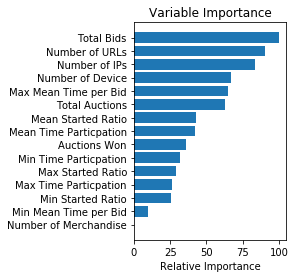

In [127]:
#Plot Feautre Importance
feature_importance = gradient_grid.best_estimator_.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Clearly, the Gradient Boost is the best model. How much lift can I get from dealing with the Class Imbalance?

## Deal with Class Imbalance

In [72]:
training_set['outcome'].value_counts()

0.0    1881
1.0     103
Name: outcome, dtype: int64

#### Up Sample

In [31]:
# Do in initial split to create hold out group

y = training_set['outcome']
X = training_set.drop(['payment_account','address'],1)

# Split the Data - Only split twice since have a test set. 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [18]:
X_train['outcome'].value_counts()

0.0    1316
1.0      72
Name: outcome, dtype: int64

In [50]:
# Do in initial split to create hold out group

y = training_set['outcome']
X = training_set.drop(['payment_account','address'],1)

# Split the Data - Only split twice since have a test set. 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# Drop outcome from X_test
X_test = X_test.drop(['outcome'],1)

# Do the upsample on the X_train

df_majority = X_train[X_train.outcome==0]
df_minority = X_train[X_train.outcome==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=100,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Rename the X_train and y_train
X_train = df_upsampled.drop(['outcome'],1)
y_train = df_upsampled['outcome']



In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1417 entries, 5720c8d7bc15b94037cd75ff9496a35evugeo to c2e1242ad5ea781923a08987d55365c69fii7
Data columns (total 15 columns):
Total Bids                1417 non-null int64
Total Auctions            1417 non-null int64
Number of Merchandise     1417 non-null int64
Number of Device          1417 non-null int64
Number of IPs             1417 non-null int64
Number of URLs            1417 non-null int64
Min Mean Time per Bid     1417 non-null float64
Max Mean Time per Bid     1417 non-null float64
Min Time Particpation     1417 non-null float64
Max Time Particpation     1417 non-null float64
Mean Time Particpation    1417 non-null float64
Min Started Ratio         1417 non-null float64
Max Started Ratio         1417 non-null float64
Mean Started Ratio        1417 non-null float64
Auctions Won              1417 non-null float64
dtypes: float64(9), int64(6)
memory usage: 177.1+ KB


Old Way

In [24]:
# Lets do a simple upsample

# Separate the majority and minority classes

df_majority = training_set[training_set.outcome==0]
df_minority = training_set[training_set.outcome==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=120,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])


In [25]:
y = df_upsampled['outcome']
X = df_upsampled.loc[:,~df_upsampled.columns.isin(['outcome','payment_account','address'])]

# Split the Data - Only split twice since have a test set. 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)



Run Model

In [95]:
#Will use Grid Search to do the cross validation.
start_time = time.time()
parameters = {'subsample':[0.9],
              'max_depth':[2],
             'n_estimators':[500]}

# Initialize the model.
clf = ensemble.GradientBoostingClassifier(max_depth=2,loss='deviance', n_estimators=800)

#Create grid and perform 5 cross validation
gradient_grid = GridSearchCV(clf, parameters, cv=8, verbose=0, scoring='roc_auc')

#Fit the Data
gradient_grid.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))


#  Test Score

gradient_prediction = gradient_grid.predict(X_test)

gradient_prediction_proba = gradient_grid.predict_proba(X_test)
gradient_prediction_proba = [p[1] for p in gradient_prediction_proba]


print(roc_auc_score(y_test, gradient_prediction_proba))

--- 4.374585390090942 seconds ---
0.9115135453474676


In [96]:
print(classification_report(y_test, gradient_prediction))

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       566
        1.0       0.63      0.40      0.49        30

avg / total       0.95      0.96      0.95       596



Im concerned with overfitting. But slightly upsampling improved recall. Which would make sense, because seeing that signal increase and maybe picking up on it. 

In [97]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


# Add prediction probability to dataframe from train set
gradient_train = gradient_grid.predict_proba(X_train)
gradient_train = [p[1] for p in gradient_train]

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_train, gradient_train)
print(threshold)

# Find prediction to the dataframe applying threshold
#data['pred'] = data['pred_proba'].map(lambda x: 1 if x > threshold else 0)

[0.5000570054465416]


In [108]:
#Applying threshold

gradient_prediction_proba_root = gradient_grid.predict_proba(X_test)
gradient_prediction_proba = [p[1] for p in gradient_prediction_proba_root]

prediction = pd.DataFrame(gradient_prediction_proba)
prediction.columns = ['Probability']
prediction['pred'] = prediction['Probability'].map(lambda x: 1 if x > 0.5 else 0)


In [109]:
print(classification_report(y_test, prediction['pred']))

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       566
        1.0       0.63      0.40      0.49        30

avg / total       0.95      0.96      0.95       596



### Down Sample

In [86]:
# Separate majority and minority classes
df_majority = training_set[training_set.outcome==0]
df_minority = training_set[training_set.outcome==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1500,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [87]:
y = df_downsampled['outcome']
X = df_downsampled.loc[:,~df_upsampled.columns.isin(['outcome','payment_account','address'])]

# Split the Data - Only split twice since have a test set. 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [88]:
#Will use Grid Search to do the cross validation.
start_time = time.time()
parameters = {'subsample':[0.95],
              'max_depth':[2],
             'n_estimators':[500]}

# Initialize the model.
clf = ensemble.GradientBoostingClassifier(max_depth=2,loss='deviance', n_estimators=800)

#Create grid and perform 5 cross validation
gradient_grid = GridSearchCV(clf, parameters, cv=8, verbose=0)

#Fit the Data
gradient_grid.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))


# Score

gradient_prediction = gradient_grid.predict(X_test)

gradient_prediction_proba = gradient_grid.predict_proba(X_test)
gradient_prediction_proba = [p[1] for p in gradient_prediction_proba]


print(roc_auc_score(y_test, gradient_prediction_proba))

--- 3.6279568672180176 seconds ---
0.8894202209813472


In [89]:
print(classification_report(y_test, gradient_prediction))

             precision    recall  f1-score   support

        0.0       0.94      0.99      0.96       443
        1.0       0.67      0.26      0.38        38

avg / total       0.92      0.93      0.92       481

